# Lesson 1: gather the tools for RL
In this notebook, you will learn:
* Create a virtual enviroment from OpenAI
* Visualize the game and know how to use it
* Create a simple model(agent) to play the game
* Reloading Agent from memory

## Import dependencies


import retro
# Note that this line will print all the games even ones for which ROMs are missing
print("Number of possible games:", len(retro.data.list_games()))
print(retro.data.list_games()[1:10])

In [2]:
# Test classical game in OpenAI
%matplotlib inline
import gym
import retro
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import deque #ordered collection with ends
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

### Get the information of the game


In [3]:
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

In [5]:
# If you want to use retro with emulator, use this
# game_name ="SpaceInvaders-Atari2600"
# env = retro.make(game=game_name)

# If you want to use simple version
game_name ="ALE/SpaceInvaders-v5"
env = gym.make(game_name)
#env = gym.make('CartPole-v1')
#env = gym.make('MountainCar-v0')
#env = gym.make('ALE/MsPacman-v5')

print("The size of the our frame is: ", env.observation_space)
print("The action size is:", env.action_space.n)
# Only works with basic games in gym
# query_environment(game_name)


height, width, channels = env.observation_space.shape
actions = env.action_space.n

# The following code could work for some games only
env.unwrapped.get_action_meanings()


The size of the our frame is:  Box(0, 255, (210, 160, 3), uint8)
The action size is: 6


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

## Visualize the game and know how to use it

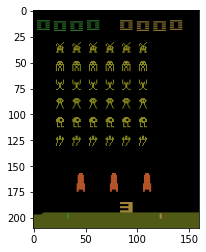

In [6]:
state=env.reset()
# A glimpse of the game
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [7]:
# To accelerate the learning, we change the output of agent as an hot encoded version of output
one_hot_actions = np.array(np.identity(env.action_space.n, dtype=int).tolist())

## Create an agent that takes random actions

Here we saved the played game as atari_trail_#.avi

You can also try to render the game if your OS supports it correctly. However, if you have several errors, check this [article](https://liveproject.manning.com/module/264_3_2/reinforcement-learning-for-self-driving-vehicles/2--optimizing-agent%27s-performance-in-openai-gym/rendering-environment-outputs-%26-q-learning?) for support. Otherwise you can use the code here to write the played games as .avi. 

In [9]:
def test_game_video(game_name,episodes, action_select):
    os.makedirs(f"played_out/{game_name}",exist_ok=True) 
    env = gym.make(game_name)
    prev_screen = env.reset()
    height, width, layers = prev_screen.shape
    for episode in range(1, episodes+1):
        state = env.reset()
        out = cv2.VideoWriter(f'played_out/{game_name}/project_{episode}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))
        done = False
        score = 0 
        while not done:
            out.write(env.render('rgb_array'))
            action = action_select(env)
            n_state, reward, done, info = env.step(action)
            score+=reward

        out.release()

        print('Episode:{} Score:{}'.format(episode, score))
    env.close()

In [11]:
# Creat an agent that takes random actions
def action_select(env):
    return env.action_space.sample()

episodes = 3
os.makedirs(f"played_out/{game_name}",exist_ok=True) 
test_game_video(game_name,episodes, action_select)


Episode:1 Score:205.0
Episode:2 Score:55.0
Episode:3 Score:540.0


### Train an agent (DQN) to play the game in a better way!

#### Preprocessing function
To simplify and increase the successful rate of training, preprocessing is an important step to reduce the complexity of our states. Here are the idea we will apply to this Atari game:
* Grayscale each frames
* Crop the screen that does not provide useful information
* Normalize pixel values
* Resize the preprocessed frame (110x84)


In [12]:
pre_process = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize([110,84]),
    transforms.Normalize(0,255),
    ] )

In [13]:
def preproccess_frame(frame):
    pre_frame = frame[8:-15, 4:-12,:]
    pre_frame = pre_process(pre_frame)
    return pre_frame
    

(210, 160, 3)
torch.Size([1, 110, 84])


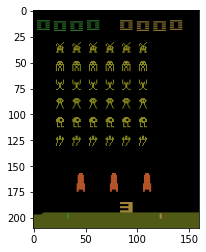

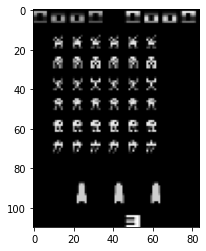

In [14]:
# Test the result of preprocessed function
print(state.shape)
preprocessed_state = preproccess_frame(state)
print(preprocessed_state.shape)
plt.imshow(state)
plt.figure()
plt.imshow(preprocessed_state[0],cmap='gray')

### Stack_frames
Intuitively we know that the sequential frames provide more accurate motion in a game. Here we are going to use four sequential frames as input states. We are going to just stack these frames but if you are interested in exploding more, you should consider the use of LSTM or other types of RNN.

Read this short [article](https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/) to understand more about the idea of giving several frmaes 

To do it, we skip 4 frames at each timestep. Here is the steps:
* Preprocess frame
* Append the frame to the deque and automatically removes the oldest frame
* Build the stacked state and feed to our agent

In [15]:
stack_size = 4
# Initialize deque with zero-images on array for each image
stacked_frames = deque([np.zeros((110,84), dtype=int) for i in range(stack_size)],maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # preprocess frame
    frame = preproccess_frame(state)

    if is_new_episode:
        #clear que
        stacked_frames = deque([np.zeros((110,84), dtype=int) for i in range(stack_size)],maxlen=4)

        #Repeate the first frame four times
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)

    stacked_state = np.stack(stacked_frames, axis=2)

    return stacked_state, stacked_frames



### Set up hyperparameters


In [16]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]      # Our input is a stack of 4 gray frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

### Create our DQN network
We are going to create a network that takes a stack of 4 frames as input and it passes through 3 convnets, then it is flatened and finally 2 fully connected layers to ouputs a Q value for each actions

In [ ]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        super(self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        # input 110x84x4
        # Formula to calculate H_out = [(H_in+2 x padding-dilation x (kernel_size-1) -1)/stride+1]
        self.conv1 = nn.Conv2d(4,32,8,stride=4, padding="valid") #output will be 20x20 feature
        self.conv2 = nn.Conv2d(32,64,4,stride=2, padding="valid") #output will be 9x9
        self.conv3 = nn.Conv2d(64,64,3,stride=2, padding="valid") #output will be 6x6
        self.fc1 = nn.Linear(64*6,512)
        self.fc2 = nn.Linear(512,6)

    def forward(self,x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = x.view(-1,32*81)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

### Replay experience
Now we need to define a training function that can learn from the replay experience and has the ability to improve itself with batch of experience. Here we'll create the Memory object that creates a deque.A deque (double ended queue) is a data type that **removes the oldest element each time that you add a new element.**

This part was taken from Udacity : <a href="https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb" Cartpole DQN</a>

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
        
def initialize_memory():
    steps = 0
    state = np.zeros((4,84,84))
    next_state = np.zeros((4,84,84))

    state_single = env.reset()
    state_single = pre_process(state_single)

    state[0,:,:] = state_single
    state[1,:,:] = state_single
    state[2,:,:] = state_single
    state[3,:,:] = state_single

    print('Starting to fill the memory with random policy')
    while steps < self.memory_burn_limit:
        #Executing a random policy
        action = LongTensor([[random.randrange(self.env.action_space.n)]])
        next_state_single, reward, is_terminal, _ = self.env.step(action[0,0])                
        #next_state_single = rgb2gray(resize(next_state_single,(84,84))) 
        next_state_single = pre_process(next_state_single)

        next_state[0,:,:] = state[1,:,:]
        next_state[1,:,:] = state[2,:,:]
        next_state[2,:,:] = state[3,:,:]
        next_state[3,:,:] = next_state_single

        if is_terminal:
            # store the transition in memory
            next_state = None
            self.memory.store(FloatTensor([state]),
                            action,
                            None,
                            FloatTensor([reward]))
        else:
            self.memory.store(FloatTensor([state]),
                            action,
                            FloatTensor([next_state]),
                            FloatTensor([reward]))


        steps += 1
        state = next_state

        #If the next_state is terminal, then you reset it
        if is_terminal:
            state_single = self.env.reset()
            #state_single = rgb2gray(resize(state_single,(84,84)))
            state_single = pre_process(state_single)

            state[0,:,:] = state_single
            state[1,:,:] = state_single
            state[2,:,:] = state_single
            state[3,:,:] = state_single
                
    print('Memory filled, ready to start training now')
    print("-"*50)
    

## Step 7: Set up Tensorboard
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=/tensorboard/dqn/1`

In [ ]:
from torch.utils.tensorboard import SummaryWriter
# writer will output to ./runs/ directory by default
writer = SummaryWriter()

### Step 8: train our agent